In [2]:
import torch
import torch.nn as nn
import numpy as np 
import random


import tqdm
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda:5")

H = torch.load("test/original_weights.pt")["H"].to(device).float()
weights = torch.load("test/original_weights.pt")["weights"].to(device).float()    

In [4]:
import sklearn.cluster as cluster

In [5]:
import torch.jit as jit

@jit.script
def cluster_e_step(X:torch.Tensor,centriods:torch.Tensor,
                   weights:torch.Tensor,
                     subblock_size:int = 1024):
    
    """
    X: torch tensor of the weights, rearanged into a shape of (n, d)
    centriods: torch.tensor of the centriods, shape of (k, d)
    weights: torch.tensor of shape (n,d)
    """

    n = X.shape[0]
    assignments = torch.zeros(n, dtype = torch.int64, device = X.device)
    
    for i in range(0, n, subblock_size):
        X_block = X[i:i+subblock_size]
        weights_block = weights[i:i+subblock_size]
        errors = (X_block.unsqueeze(-1) - centriods.T.unsqueeze(0))**2
        #shape of (n, d, k)

        #multiply by the diagonal
        errors = errors * weights_block.unsqueeze(-1)

        #sum by the d
        errors = errors.sum(1)
        #shape of (n, k)
        # print(errors[0,10,:])
        assignments_block = errors.argmin(-1)
        # print(assignments_block[0,10])
        assignments[i:i+subblock_size] = assignments_block
    # errors = (X.unsqueeze(-1) - centriods.T.unsqueeze(0))**2
    # #shape of (n, d, k)

    # #multiply by the diagonal
    # errors = errors * weights.unsqueeze(-1)

    # #sum by the d
    # errors = errors.sum(1)
    # # print("errors[0,10,:] = ", errors[0,10,:])
    # #shape of (n, k)
    # # print(errors[0,10,:])
    # assignments = errors.argmin(-1)
    # # print("assignments[0,10] = ", assignments[0,10])
    # # print("="*10)
    # #shape of (n)
    return assignments

@jit.script
def cluster_m_step(X:torch.Tensor, assignments:torch.Tensor, k:int, weights:torch.Tensor):
    """
    X: torch tensor of the weights, rearanged into a shape of (n, d)
    assignments: torch.tensor of the assignments, shape of (n)
    k: int, number of clusters
    weights: torch.tensor of shape (n, d)
    """
    n, d = weights.shape

    #compute the new centriods
    centriods = torch.zeros((k,d), dtype = weights.dtype, device = weights.device)
    #shape of (k,d)
    for i in range(k):
        assignment_X = X[assignments == i] #shape of (n_i,d)
        assignments_weights = weights[assignments == i] #shape of (n_i,d)

        centriods[i] = torch.sum(assignments_weights * assignment_X, dim = 0) / torch.sum(assignments_weights, dim = 0)

    return centriods

# @jit.script
def our_cluster(X:torch.Tensor, k:int, weights:torch.Tensor, n_iter:int = 100):
    """
    weights: torch tensor of the weights, rearanged into a shape of (n, d)
    k: int, number of clusters
    weights: torch.tensor of shape (n, d)
    n_iter: int, number of iterations
    """
    n, d = weights.shape


    n_1 = torch.from_numpy(np.random.choice(n, k, replace = False)).to(device)
    centriods = X[n_1, :]
    centriods[0,:] = 0
        # print(centriods)
    #shape of (k, d)
    for i in range(n_iter):
        # print("X.shape = ", X.shape, "centriods.shape = ", centriods.shape, "weights.shape = ", weights.shape)
        assignments = cluster_e_step(X, centriods, weights)
        # print(assignments)
        # print(assignments.shape)
        centriods = cluster_m_step(X, assignments, k, weights)
        
        centriods[torch.argmin(torch.norm(centriods, dim = 1))] = 0
        if i > 0:
            if torch.all(assignments == assignments_old):
                # print("breaking at iteration", i)
                break
            # print("n_change:", torch.sum(assignments != assignments_old))
        assignments_old = assignments.clone()
    return assignments, centriods
    



In [6]:
a = torch.tensor([[1,2],[3,4]]).float()

torch.norm(a, dim = 1)

tensor([2.2361, 5.0000])

In [23]:
torch.random.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
def create_mask(data,percent_top):
    """
    data: torch.tensor of shape (n)
    percent_top: float, the percentage of the top values to keep
    """

    threshold = torch.quantile(data, 1-percent_top/100)
    return data < threshold


d = 4
percent_dense_rowise = 0.7
percent_dense_columnwise = 1


row_mask = create_mask(torch.norm(weights, dim = 1), percent_dense_rowise)
column_mask = create_mask(torch.norm(weights, dim = 0), percent_dense_columnwise) & create_mask(torch.norm(H, dim = 0), percent_dense_columnwise)

print("row_mask.sum() = ", row_mask.sum())
print("column_mask.sum() = ", column_mask.sum())


def mask_round(mask, d):

    while mask.sum() % d != 0:
        mask[torch.randint(0, mask.shape[0], (1,))] = False

    return mask

row_mask = mask_round(row_mask, d)
column_mask = mask_round(column_mask, d)

mask = row_mask.unsqueeze(1) & column_mask.unsqueeze(0)

print("row_mask.sum() = ", row_mask.sum())
print("column_mask.sum() = ", column_mask.sum())


row_mask.sum() =  tensor(4067, device='cuda:5')
column_mask.sum() =  tensor(4052, device='cuda:5')
row_mask.sum() =  tensor(4064, device='cuda:5')
column_mask.sum() =  tensor(4052, device='cuda:5')


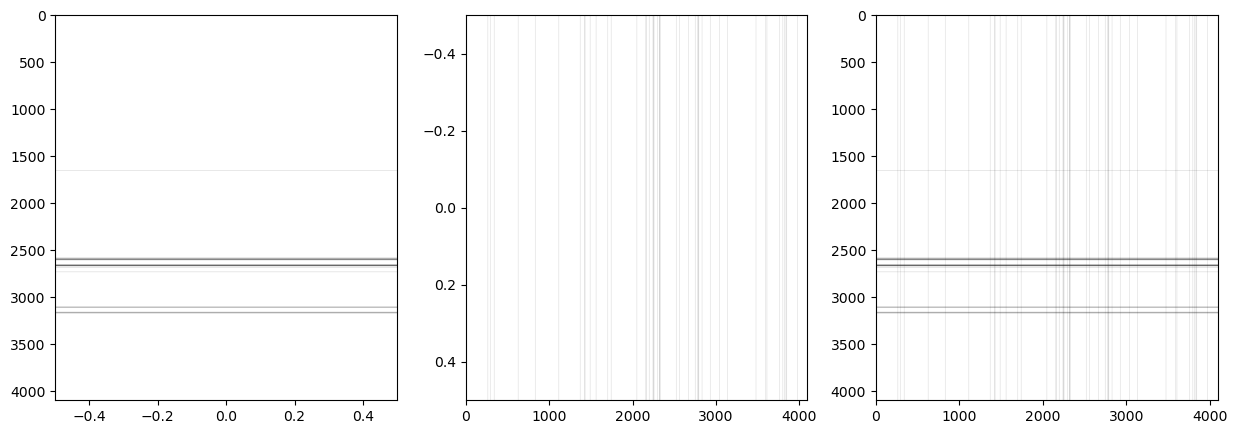

In [24]:
cmap = "gray"
fig,axs = plt.subplots(1,3, figsize = (15,5))

plt.sca(axs[0])
plt.imshow(row_mask.unsqueeze(1).cpu().numpy(), cmap = cmap, aspect = "auto")
plt.sca(axs[1])
plt.imshow(column_mask.unsqueeze(0).cpu().numpy(), cmap = cmap, aspect = "auto")
plt.sca(axs[2])
plt.imshow(mask.cpu().numpy(), cmap = cmap, aspect = "auto")

In [25]:
torch.sum(column_mask)

tensor(4052, device='cuda:5')

In [26]:
torch.sum(mask)/4044

tensor(4072.0393, device='cuda:5')

In [27]:
weights_masked.shape

torch.Size([4064, 4044])

In [28]:
torch.random.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
import tqdm
import sklearn.cluster

n_iters = 25

grouping = torch.sum(column_mask) * 128
d = 4
k_coseine_codebook = 2**(4*2)
keep_top = 0.01

# print("average bits:", (np.log2(k_magnitude_codebook) + np.log2(k_coseine_codebook))/d)

def get_bytes(bits):
    #return as MB
    return bits/8/1024/1024

print(torch.sum(mask).item()/grouping)

overhead = k_coseine_codebook * 16 * d * torch.sum(mask).item()/grouping

encoding_bits = (np.ceil(np.log2(k_coseine_codebook)))/d * torch.sum(mask).item()

sparse_bits = 16 * torch.sum(~mask).item()
print("sparse bits:", sparse_bits/weights.numel(),
        "encoding bits:", encoding_bits/weights.numel(),
        "overhead:", overhead/weights.numel())

print("bits per value:", (sparse_bits + encoding_bits + overhead)/(weights.shape[0] * weights.shape[1]))
raise ValueError


weights_masked = weights[row_mask,:][:,column_mask]
print("weights_masked.shape = ", weights_masked.shape)
subvector_assignments = torch.arange(weights_masked.shape[1]).reshape((-1, d))
# row_assignments = torch.randperm(weights.shape[1]).reshape(-1, d)

# assert torch.isfinite(weights_masked).all()
# assert torch.isfinite(H).all()

weights_reshaped = weights_masked[:,subvector_assignments] 
print("weights_reshaped.shape = ", weights_reshaped.shape)
#shape of (n, m/d, d)

print(H[column_mask,column_mask].shape)
H_diag = H[column_mask,column_mask][subvector_assignments]
print("H_diag.shape = ", H_diag.shape)
# H_diag = torch.ones_like(weights_reshaped)
#shape of (n, m/d, d)

# raise ValueError
# print(torch.quantile(weights_norms, 1-keep_top), torch.max(weights_norms), torch.min(weights_norms))
# print(torch.sum(mask)/(mask.shape[0]*mask.shape[1]), 1 - torch.sum(mask)/(mask.shape[0]*mask.shape[1]))
# raise ValueError
#mask of the top 1% of the weights


print("weights_norms_masked.shape", weights_reshaped.shape)


mappings, codebooks = our_cluster(weights_reshaped.reshape(-1,d), k_coseine_codebook, H_diag.unsqueeze(0).expand(weights_reshaped.shape[0], -1, -1).reshape(-1,d), n_iter = n_iters)
#mapping of shape (m/d*n)
#codebooks of shape (k, d)

weights_reconstructed = torch.empty_like(weights_masked)
weights_reconstructed[:,subvector_assignments] = codebooks[mappings,:].reshape(weights_reconstructed.shape[0], -1, d)




weights_quantized = torch.empty_like(weights)

weights_quantized[mask] = weights_reconstructed.flatten()
weights_quantized[~mask] = weights[~mask]


diff = weights - weights_quantized

average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)

H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)

free, total = torch.cuda.mem_get_info(device)
print(f"free = {free/1024/1024}, total = {total/1024/1024}")

print(f"average error {average_error}, H error {H_error}")

tensor(4064.0002, device='cuda:5')
sparse bits: 0.2955322265625 encoding bits: 1.9630584716796875 overhead: tensor(3.9688, device='cuda:5')
bits per value: tensor(6.2273, device='cuda:5')


ValueError: 

In [22]:
0.0310*128

3.968

In [9]:
codebooks

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0320, -0.0396, -0.0030, -0.0167],
        [ 0.0049, -0.0041,  0.0284,  0.0059],
        ...,
        [-0.0106, -0.0084,  0.0246, -0.0368],
        [-0.0037,  0.0386,  0.0462, -0.0283],
        [-0.1039,  0.0030, -0.0499, -0.0391]], device='cuda:5')

In [10]:
frac_to_bin_to_zero = 0.0

codebook_norms = torch.norm(codebooks, dim = 1)
sorted_indexs = torch.argsort(codebook_norms)
zero_index = torch.argmin(codebook_norms)

mappings_new = mappings.clone()

frac_binned = 0
i = 0
while frac_binned < frac_to_bin_to_zero:
    frac_binned += torch.sum(mappings_new == sorted_indexs[i])/mappings_new.shape[0]
    mappings_new[mappings_new == sorted_indexs[i]] = zero_index
    i += 1
    
weights_reconstructed = torch.empty_like(weights_masked)
weights_reconstructed[:,subvector_assignments] = codebooks[mappings_new,:].reshape(weights_reconstructed.shape[0], -1, d)




weights_quantized = torch.empty_like(weights)

weights_quantized[mask] = weights_reconstructed.flatten()
weights_quantized[~mask] = weights[~mask]


diff = weights - weights_quantized

average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)

H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)

free, total = torch.cuda.mem_get_info(device)
print(f"free = {free/1024/1024}, total = {total/1024/1024}")

print(f"average error {average_error}, H error {H_error}")
    
unique_mappings, counts = torch.unique(mappings_new, return_counts = True)
print("unique_mappings.shape = ", unique_mappings.shape)
entropy = -torch.sum(counts/torch.sum(counts) * torch.log2(counts/torch.sum(counts)))
print("entropy = ", entropy)
    



free = 47265.0, total = 48676.75
average error 0.18199363350868225, H error 0.4525001347064972
unique_mappings.shape =  torch.Size([4096])
entropy =  tensor(11.8933, device='cuda:5')


In [11]:
class huff_node:
    def __init__(self, value, count):
        self.value = value
        self.count = count
        self.left = None
        self.right = None
        self.code = ""

def huffman_code_recursive(nodes:list[huff_node]):
    if len(nodes) == 1:
        
        return nodes[0]
    nodes = sorted(nodes, key = lambda x: x.count)
    new_node = huff_node(None, nodes[0].count + nodes[1].count)
    new_node.left = nodes[0]
    new_node.right = nodes[1]
    return huffman_code_recursive([new_node] + nodes[2:])

def huffman_code_generate(node:huff_node):
    if node.left is not None:
        node.left.code = node.code + "0"
        huffman_code_generate(node.left)
    if node.right is not None:
        node.right.code = node.code + "1"
        huffman_code_generate(node.right)

def huffman_code(values,counts):
    nodes = [huff_node(value, count) for value, count in zip(values,counts)]
    root = huffman_code_recursive(nodes)
    huffman_code_generate(root)
    return {node.value: node.code for node in nodes}

In [14]:
unique_mappings.shape

torch.Size([4096])

In [12]:
codes = huffman_code(unique_mappings.cpu().numpy(), counts.cpu().numpy())

n_bits = torch.zeros(k_coseine_codebook, dtype = torch.int64).to(device)

for index in unique_mappings:
    n_bits[index] += len(codes[index.item()])

print("n_bits.shape = ", n_bits.shape)
d_big = 32
n_bits_per_value = n_bits[mappings_new].reshape(-1,d_big).sum(1)
target_n_bits = 2 * d_big * d
print("frac_violations", torch.sum(n_bits_per_value > target_n_bits)/n_bits_per_value.shape[0])

RecursionError: maximum recursion depth exceeded

In [69]:
n_bits[mappings_new].reshape(-1,d_big)[torch.argmax(n_bits_per_value)]

tensor([14, 12, 14, 14, 14, 13, 14, 14, 14, 14, 12, 14, 14, 14, 16, 13, 15, 13,
        15, 13, 13, 14, 13, 15, 14, 13, 12, 14, 14, 13, 14, 14],
       device='cuda:5')

In [70]:
codebooks[n_bits == 8].shape

torch.Size([0, 4])

In [71]:
torch.max(n_bits)

tensor(17, device='cuda:5')

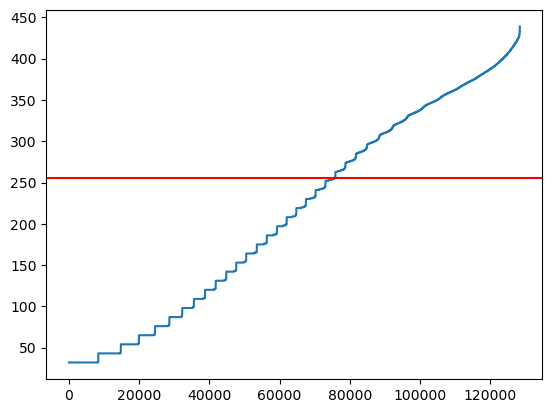

In [72]:
plt.plot(np.sort(n_bits_per_value.cpu().numpy()))    
plt.axhline(target_n_bits, color = "red")

In [67]:
mappings_new.shape[0]/(32)

128397.0

In [20]:
target_n_bits

112.0

entropy: tensor(7.5073, device='cuda:5')


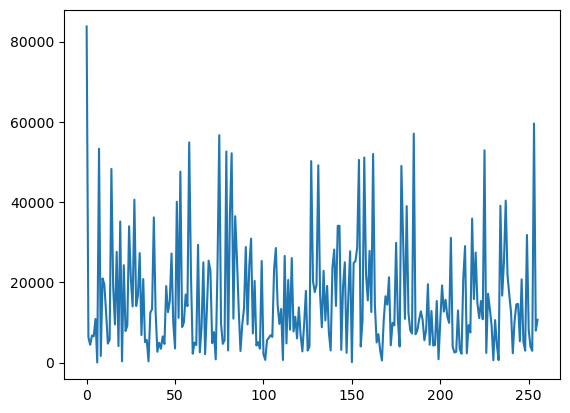

In [17]:
unique_mappings, counts = torch.unique(mappings, return_counts = True)

plt.plot(counts.cpu().numpy())
entropy = -torch.sum((counts/counts.sum())*torch.log2(counts/counts.sum()))
print("entropy:", entropy)

(array([2.072253e+06, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 1.473610e+05, 1.787250e+05,
        2.047590e+05, 1.485940e+05, 1.518200e+05, 1.210450e+05,
        6.986200e+04, 1.627030e+05, 7.561100e+04, 5.757500e+04,
        1.202450e+05, 8.202500e+04, 9.438600e+04, 3.497200e+04,
        5.468500e+04, 3.663700e+04, 2.930500e+04, 2.656100e+04,
        1.292800e+04, 1.174100e+04, 2.828100e+04, 2.072900e+04,
        2.393700e+04, 3.685300e+04, 8.633000e+03, 2.026800e+04,
        0.000000e+00, 7.576000e+03, 1.656400e+04, 1.205600e+04,
        1.222800e+04, 8.054000e+03, 2.400000e+03, 4.649000e+03,
        9.250000e+03, 0.000000e+00, 4.428000e+03, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.645000e+03,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 8.310000e+02, 6.660000e+02,
        0.000000e+00, 8.050000e+02, 6.17

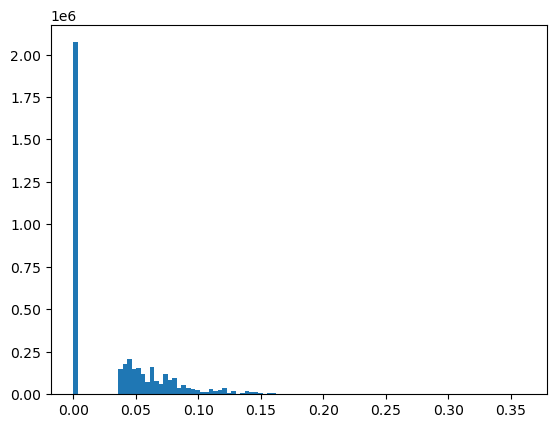

In [35]:
plt.hist(torch.norm(codebooks, dim = 1)[mappings_new].cpu().numpy(), bins = 100)    